## Importing libraries

In [1]:
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("science")

## Monge formulation

Let $(\Omega_{X}, F_{X}, \mu)$ and $(\Omega_{Y}, F_{Y}, \nu)$ be two probability spaces with $\mu$ and $\nu$ discrete measures.
The Monge formulation of the optimal transport problem is 

<font color="blue">
$$\min \left\{ \sum_{X} c_{T}(x) \mu(x) : T_{\#}(\mu) = \nu \right\}$$
</font>

where $T_{\#}$ is the pushforward measure of $\mu$ by $T$.

If $X: \Omega_{X} \rightarrow \mathbb{R}$ and $Y: \Omega_{Y} \rightarrow \mathbb{R}$ are two discrete random variables with $\Omega_{X} = \Omega_{Y} = [1, \ldots, N]$, this formulation is equivalent to

<font color="blue">
$$ \begin{array}{c}\text{min}\\ \sigma \in \Pi_{N}\end{array}
\left\{ \sum_{i=1}^{N} C_{i},\sigma(i) \right\}$$
</font>

where $\Pi_{N}$ is the set of all the permutation matrices of $\{1, \ldots, N\} \text{x} \{1, \ldots, N\}$, $\sigma \in \Pi_{N}$ a permutation matrix and $\sigma(i)$ the ith row of $\sigma$.

## Bakeries and cafeterias

Suppose we have N bakeries and N cafeterias. A bakery can deliver to only one cafeteria. The cost of the ith bakery supplying the jth cafeteria is given by the following matrix

In [2]:
N = 6
C = np.array([[12., 10., 31., 27., 10., 30.],
              [22.,  7., 25., 15., 11., 14.],
              [19.,  7., 19., 10., 15., 15.],
              [10.,  6., 21., 19., 14., 24.],
              [15., 23., 14., 24., 31., 34.],
              [35., 26., 16.,  9., 34., 15.]])

In [3]:
C.shape

(6, 6)

We want to minimize the total cost of supplying all the N cafeterias.
This is a problem of finding an optimal transport map i.e. an application T that maps a bakery to a cafeteria 
and minimizes the total cost.

The number of possibilities is

$$
\begin{align}
\left( \begin{array}{cc}6\\1\end{array} \right) * \left( \begin{array}{cc}5\\1\end{array} \right) * ... * \left( \begin{array}{cc}2\\1\end{array} \right) * 1 = 6!
\end{align}
$$

In [4]:
math.factorial(6)

720

One of these 720 possibilities is for the ith bakery to supply the ith cafeteria. The permutation matrix is $\sigma = I_{N}$ the identity matrix. The cost is the sum of the diagonal 

In [5]:
np.diag(C).sum()

103.0

Instead of testing all the N! possible solutions which is impractical, we formulate the problem as follow

$$\begin{array}{c}\text{min}\\ \sigma \in \Pi_{N}\end{array} \left\{ \sum_{i=1}^{N} C_{i},\sigma(i) \right\}$$

where $C$ is the cost and $\sigma$ is a permutation matrix of $\{1, \ldots, N\} \text{x} \{1, \ldots, N\}$

## Optimal transport as minimum cost bipartite matching

Let's construct a graph where both the bakeries and the cafeterias are the nodes

In [6]:
g = nx.Graph()

In [7]:
nodes_x = ['x' + str(_x) for _x in list(range(N))]
nodes_y = ['y' + str(_y) for _y in list(range(N))]
print("Nodes x :", *nodes_x)
print("Nodes y :", *nodes_y)

Nodes x : x0 x1 x2 x3 x4 x5
Nodes y : y0 y1 y2 y3 y4 y5


**Adding the nodes to the graph**

In [8]:
for node in nodes_x + nodes_y:
    g.add_node(node)

**Adding the edges**

In [9]:
for i in range(N):
    for j in range(N):
        g.add_edge(nodes_x[i], nodes_y[j], weight=C[i, j])

**Drawing the bipartite graph**

In [10]:
def draw_bipartite_graph(g, filename = ""):
    fig = plt.figure(figsize=(5, 2))
    pos = nx.bipartite_layout(g, nodes_x, align = 'horizontal')
    nx.draw_networkx_nodes(g, pos, nodelist=nodes_x, node_color = 'darkblue', node_size = 400)
    nx.draw_networkx_nodes(g, pos, nodelist=nodes_y, node_color = 'darkred', node_size = 400)
    nx.draw_networkx_labels(g, pos, font_color = 'w')
    edge_labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos, edge_labels)
    nx.draw_networkx_edges(g, pos)
    plt.axis('off')
    plt.tight_layout()
    if filename != "":
        plt.savefig(filename)
    plt.show()

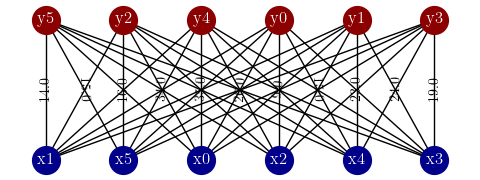

In [11]:
draw_bipartite_graph(g)

This is a bipartite graph, its vertices are divided into two disjoint sets $X = \{ x_{0}, x_{1}, ..., x_{5} \}$ and
$Y = \{ y_{0}, y_{1}, ..., y_{5}\}$

The optimal transport problem formulated above is the problem finding a matching in a bipartite graph for which the sum of the weight of the edges is minimum.

**Solving the problem**

Many polynomial time (in the number of vertices $N$) algorithms for solving this problem exists.
The Hopcroft-karp algotihm is implemented in scipy and can be called from networkx to find the minimum bipartite matching of a graph.

In [12]:
res = nx.bipartite.minimum_weight_full_matching(g)
res

{'x1': 'y5',
 'x5': 'y3',
 'x0': 'y4',
 'x2': 'y1',
 'x4': 'y2',
 'x3': 'y0',
 'y5': 'x1',
 'y3': 'x5',
 'y4': 'x0',
 'y1': 'x2',
 'y2': 'x4',
 'y0': 'x3'}

The minimum cost is the sum of the weights

In [13]:
min_cost = 0.
for src, dest in res.items():
    min_cost += g.get_edge_data(src, dest)['weight']
min_cost /= 2

The minimum cost is

In [14]:
min_cost

64.0

**Visual checking**

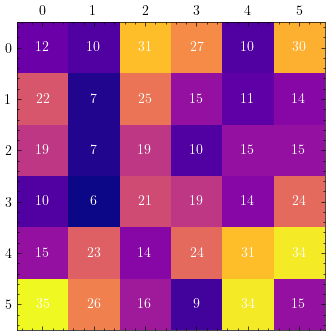

In [15]:
fig, ax = plt.subplots(figsize = (4, 4))
ax.matshow(C, cmap = mpl.colormaps["plasma"])
for i in range(N):
    for j in range(N):
        nodex = nodes_x[i]
        nodey = nodes_y[j]
        if (res[nodex] == nodey):
            color = 'white'
        else:
            color = 'white'
        ax.text(j, i, int(C[i, j]), horizontalalignment = 'center',
                verticalalignment = 'center', weight = 'bold', color = color)

If we sum the values in white we have indeed the minimum cost

In [16]:
10 + 7 + 14 + 9 + 10 + 14

64

The solution is for the bakery 3 to supply the cafeteria 0, the bakery 2 to supply the cafeteria 1, 
the bakery 4 to supply the cafeteria 2 and so on...

The optimal transport matrix is 

In [17]:
z = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        x = nodes_x[i]
        y = nodes_y[j]
        z[i,j] = (res[x] == y)
z

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

z is the permutation matrix that minimizes the transportation cost

$$z = \begin{array}{c}\text{argmin}\\ \sigma \in \Pi_{N}\end{array} \sum_{i=1}^{N} C_{i},\sigma(i)$$